In [1]:
import os
import sys


def setup_project_root(start_path='.'):
    """Find the project root, set it as the current working directory, and add it to sys.path."""
    current_path = os.path.abspath(start_path)
    while True:
        if '.git' in os.listdir(current_path):
            project_root = current_path
            break
        parent_path = os.path.dirname(current_path)
        if parent_path == current_path:  # We've reached the root directory
            raise Exception("Could not find project root (.git directory not found)")
        current_path = parent_path
    
    # Change the current working directory to the project root
    os.chdir(project_root)
    print(f"Current working directory set to: {os.getcwd()}")

    # Add project root to sys.path if it's not already there
    if project_root not in sys.path:
        sys.path.insert(0, project_root)
        print(f"Added {project_root} to sys.path")

# sets the current working directory to the project root
setup_project_root()

# Don't cache imports
%load_ext autoreload
%autoreload 2


Current working directory set to: /vol/bitbucket/dm2223/info-theory-experiments


In [ ]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def create_glider(grid, x, y):
    glider = torch.tensor([[0, 1, 0],
                           [0, 0, 1],
                           [1, 1, 1]], dtype=torch.float32)
    grid[x:x+3, y:y+3] = glider

def update_grid(grid):
    N = grid.shape[0]
    total = (
        grid.roll(1, 0) + grid.roll(-1, 0) +
        grid.roll(1, 1) + grid.roll(-1, 1) +
        grid.roll(1, 0).roll(1, 1) + grid.roll(1, 0).roll(-1, 1) +
        grid.roll(-1, 0).roll(1, 1) + grid.roll(-1, 0).roll(-1, 1)
    )
    return ((grid == 1) & ((total == 2) | (total == 3))) | ((grid == 0) & (total == 3))

def run_game_of_life(N, steps, seed):
    torch.manual_seed(seed)
    
    grid = torch.zeros((N, N), dtype=torch.float32)
    x, y = torch.randint(0, N-3, (2,))
    create_glider(grid, x, y)
    
    grids = [grid.clone()]
    for _ in range(steps - 1):
        grid = update_grid(grid).float()
        grids.append(grid.clone())
    
    return torch.stack(grids)

def animate_game_of_life(grids):
    fig, ax = plt.subplots()
    img = ax.imshow(grids[0].cpu().numpy(), interpolation='nearest', cmap='binary')
    
    def update(frame):
        img.set_array(grids[frame].cpu().numpy())
        return [img]
    
    ani = FuncAnimation(fig, update, frames=len(grids), interval=200, blit=True)
    plt.close(fig)  # Prevent the static plot from displaying
    return ani

def animate_game_of_life_with_vector(grids, vector):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 10))
    
    img = ax1.imshow(grids[0].cpu().numpy(), interpolation='nearest', cmap='binary')
    line, = ax2.plot([], [], lw=2)
    
    vector = vector.flatten()  # Ensure vector is 1D
    
    ax2.set_xlim(0, len(vector) - 1)
    ax2.set_ylim(min(vector), max(vector))
    ax2.set_xlabel('Frame')
    ax2.set_ylabel('Vector Value')
    
    def init():
        line.set_data([], [])
        return [img, line]
    
    def update(frame):
        img.set_array(grids[frame].cpu().numpy())
        line.set_data(range(frame + 1), vector[:frame + 1])
        return [img, line]
    
    ani = FuncAnimation(fig, update, frames=len(grids), init_func=init, interval=200, blit=True)
    plt.close(fig)  # Prevent the static plot from displaying
    return ani

# # Set parameters
# N = 10  # Grid size
# steps = 50  # Number of time steps
# seed = 42  # Random seed

# # Check if CUDA is available and set the device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Run the Game of Life simulation
# grids = run_game_of_life(N, steps, seed).to(device)

# # Create and display the animation
# ani = animate_game_of_life(grids)
# from IPython.display import HTML
# HTML(ani.to_jshtml())

# print(f"Shape of the tensor: {grids.shape}")
# print(f"Type of the tensor: {grids.dtype}")
# print(f"Device of the tensor: {grids.device}")


In [ ]:
from custom_datasets import GameOfLifeDatasetNoLoopNoPrepare
from models import GameOfLifeCNN
from matplotlib.animation import FuncAnimation
import torch
import matplotlib.pyplot as plt

def animate_game_of_life_with_vector(grids, vector):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 10))
    
    img = ax1.imshow(grids[0].cpu().numpy(), interpolation='nearest', cmap='binary')
    line, = ax2.plot([], [], lw=2)
    
    vector = vector.flatten()  # Ensure vector is 1D
    
    ax2.set_xlim(0, len(vector) - 1)
    ax2.set_ylim(min(vector), max(vector))
    ax2.set_xlabel('Frame')
    ax2.set_ylabel('Vector Value')
    
    def init():
        line.set_data([], [])
        return [img, line]
    
    def update(frame):
        img.set_array(grids[frame].cpu().numpy())
        line.set_data(range(frame + 1), vector[:frame + 1])
        return [img, line]

    ani = FuncAnimation(fig, update, frames=len(grids), init_func=init, interval=200, blit=True)
    plt.close(fig)  # Prevent the static plot from displaying
    return ani

data = GameOfLifeDatasetNoLoopNoPrepare().data
print(data.size())
grids = data[:200].to('cuda')

model = GameOfLifeCNN(output_dim=1).to('cuda')

# load models/NEURIPS-GOL-model-A-northern-universe-18.pth
model.load_state_dict(torch.load('models/NEURIPS-GOL-model-A-rand-shape-init-skilled-waterfall-2.pth'))

reps = model(grids)

print(reps.size())

# Create and display the animation
ani = animate_game_of_life_with_vector(grids, reps.cpu().detach().numpy())
from IPython.display import HTML
HTML(ani.to_jshtml())

print(f"Shape of the tensor: {grids.shape}")
print(f"Type of the tensor: {grids.dtype}")
print(f"Device of the tensor: {grids.device}")

from IPython.display import HTML
HTML(ani.to_jshtml())


# Predict glider state from feature

torch.Size([73012, 10, 10])


/tmp/ipykernel_272587/1956308398.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/NEURIPS-GOL-model-A-rand-shape-init-unique-clo

Epoch [1/130], Loss: 1.3928, Accuracy: 0.2368, Verification Accuracy: 0.2450
Epoch [2/130], Loss: 1.3894, Accuracy: 0.2368, Verification Accuracy: 0.2450
Epoch [3/130], Loss: 1.3873, Accuracy: 0.2368, Verification Accuracy: 0.2450
Epoch [4/130], Loss: 1.3853, Accuracy: 0.2392, Verification Accuracy: 0.2000
Epoch [5/130], Loss: 1.3829, Accuracy: 0.2410, Verification Accuracy: 0.2400
Epoch [6/130], Loss: 1.3805, Accuracy: 0.2834, Verification Accuracy: 0.2900
Epoch [7/130], Loss: 1.3781, Accuracy: 0.3010, Verification Accuracy: 0.4500
Epoch [8/130], Loss: 1.3754, Accuracy: 0.4181, Verification Accuracy: 0.3850
Epoch [9/130], Loss: 1.3723, Accuracy: 0.3542, Verification Accuracy: 0.3650
Epoch [10/130], Loss: 1.3689, Accuracy: 0.3508, Verification Accuracy: 0.3650
Epoch [11/130], Loss: 1.3650, Accuracy: 0.3485, Verification Accuracy: 0.3750
Epoch [12/130], Loss: 1.3604, Accuracy: 0.3457, Verification Accuracy: 0.3650
Epoch [13/130], Loss: 1.3550, Accuracy: 0.3625, Verification Accuracy: 0.

validation accuracy,▂▁▅▄▅▅▅▄▄▄▅▅▅▆▅▅▆▆▇▆▇▇▇▇▇▇▇▇▇██████▇██▇▇
validation accuracy,0.515


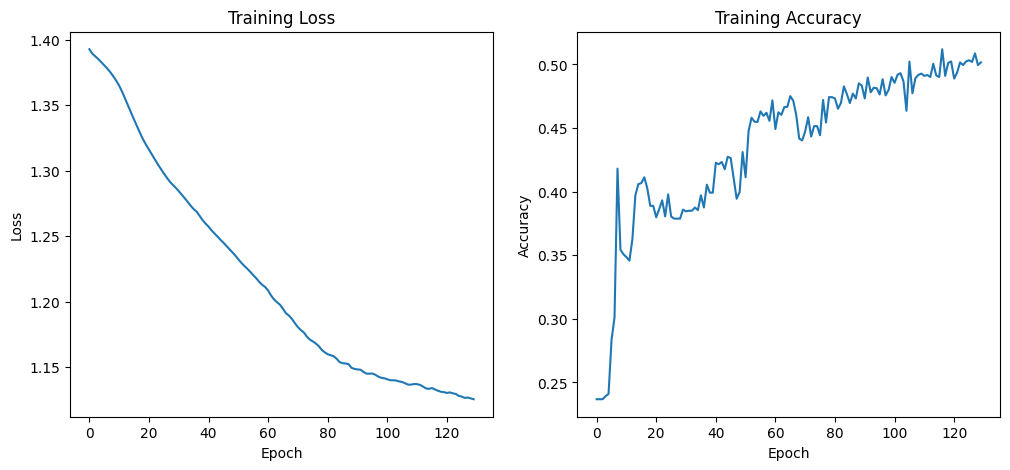

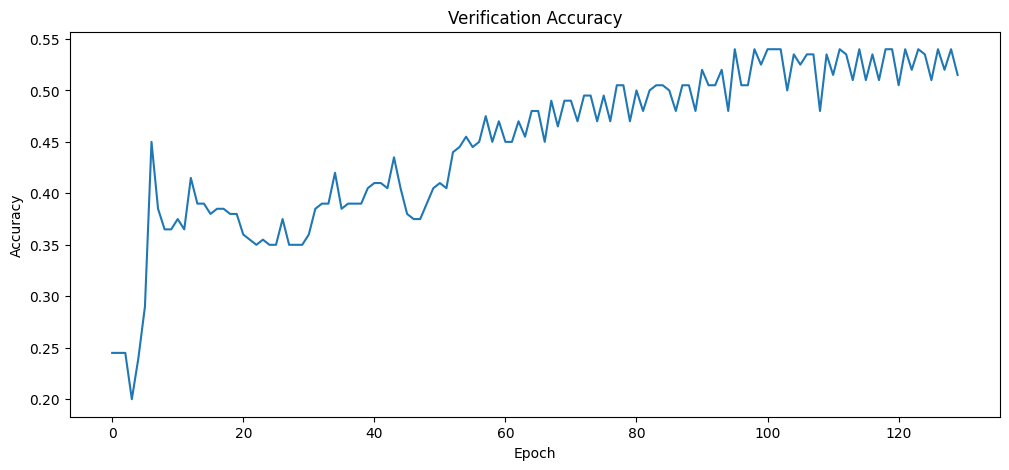

0.54


In [1]:
import torch
import torch.nn.functional as F
from custom_datasets import GameOfLifeDatasetNoLoopNoPrepare
from models import GameOfLifeCNN
import wandb


shape1 = torch.tensor([[0, 1, 0],
                       [0, 0, 1],
                       [1, 1, 1]], dtype=torch.float32)

shape2 = torch.tensor([[1, 0, 1],
                       [0, 1, 1],
                       [0, 1, 0]], dtype=torch.float32)

shape3 = torch.tensor([[0, 0, 1],
                       [1, 0, 1],
                       [0, 1, 1]], dtype=torch.float32)

shape4 = torch.tensor([[1, 0, 0],
                       [0, 1, 1],
                       [1, 1, 0]], dtype=torch.float32)

kernels = torch.stack([shape1, shape2, shape3, shape4]).unsqueeze(1)

def detect_glider(grids):
    batch_size, height, width = grids.shape
    
    # Move kernels to the same device as grids
    kernels_cuda = kernels.to(grids.device)
    
    # Perform convolution for each shape
    conv_results = F.conv2d(grids.unsqueeze(1), kernels_cuda, padding=0)
    
    # Find the maximum value for each shape across all positions
    max_values, _ = conv_results.view(batch_size, 4, -1).max(dim=2)
    
    # Find which shape has the highest match (should be 3 for a perfect match)
    shape_index = max_values.argmax(dim=1)
    
    # Create one-hot encoding
    one_hot = F.one_hot(shape_index, num_classes=4).float()
    
    return one_hot


data = GameOfLifeDatasetNoLoopNoPrepare().data

print(data.size())

verification_number = 200
grids = data.to('cuda')

verification_grids = grids[:verification_number]
grids = grids[verification_number:]

labels = detect_glider(grids) 

model = GameOfLifeCNN(output_dim=1).to('cuda')

model.load_state_dict(torch.load('models/NEURIPS-GOL-model-A-rand-shape-init-unique-cloud-3.pth'))

reps = model(grids)
verification_reps = model(verification_grids)

import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the larger MLP model
class BiggerStrongerMLP(nn.Module):
    def __init__(self):
        super(BiggerStrongerMLP, self).__init__()
        self.fc1 = nn.Linear(1, 512) 
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 4)  # Assuming output_dim is 4
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Initialize the larger and stronger MLP model
mlp = BiggerStrongerMLP().to('cuda')

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

reps = model(grids)
labels = detect_glider(grids) 

losses = []
accuracies = []
verification_accuracies = []
# Training loop
num_epochs = 130
wandb.init(project='GOL-accuracy')
for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = mlp(reps.detach())
    loss = criterion(outputs, labels.argmax(dim=1))
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    # Calculate accuracy
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels.argmax(dim=1)).sum().item()
    accuracy = correct / labels.size(0)
    accuracies.append(accuracy)


    # Calculate verification accuracy
    verification_outputs = mlp(verification_reps)
    _, verification_predicted = torch.max(verification_outputs, 1)
    verification_correct = (verification_predicted == detect_glider(verification_grids).argmax(dim=1)).sum().item()
    verification_accuracy = verification_correct / verification_grids.size(0)
    verification_accuracies.append(verification_accuracy)

    wandb.log({'validation accuracy': verification_accuracy})


    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, Verification Accuracy: {verification_accuracy:.4f}')

wandb.finish()

# Predict labels from the reps after training
mlp.eval()
with torch.no_grad():
    predicted_labels = mlp(reps)

# Optionally, you can apply a softmax to get probabilities
predicted_probs = F.softmax(predicted_labels, dim=1)

import matplotlib.pyplot as plt
# plot the loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

# plot the verification accuracy
plt.figure(figsize=(12, 5))
plt.plot(verification_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Verification Accuracy')

plt.show()

# max verification accuracy
print(max(verification_accuracies))



## confusing matrix for state classification

Class counts in verification data: {0: 49, 1: 51, 2: 53, 3: 47}


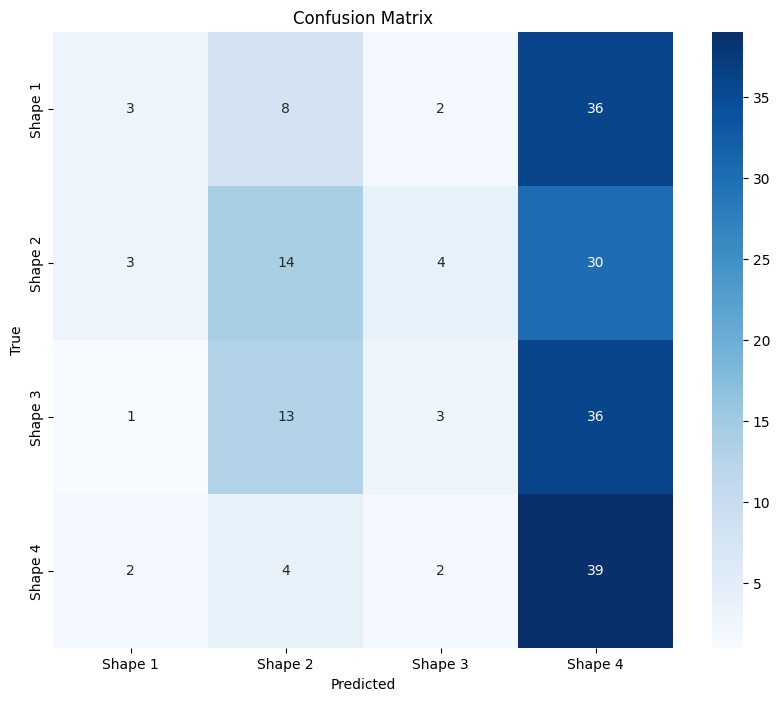

              precision    recall  f1-score   support

     Shape 1       0.33      0.06      0.10        49
     Shape 2       0.36      0.27      0.31        51
     Shape 3       0.27      0.06      0.09        53
     Shape 4       0.28      0.83      0.41        47

    accuracy                           0.29       200
   macro avg       0.31      0.31      0.23       200
weighted avg       0.31      0.29      0.23       200



In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get predictions for verification data
mlp.eval()
with torch.no_grad():
    verification_outputs = mlp(verification_reps)
    _, verification_predicted = torch.max(verification_outputs, 1)

# Get true labels for verification data
verification_true = detect_glider(verification_grids).argmax(dim=1)


# Count the number of each class and print
unique, counts = np.unique(verification_true.cpu().numpy(), return_counts=True)
class_counts = dict(zip(unique, counts))
print("Class counts in verification data:", class_counts)


# Move tensors to CPU and convert to numpy arrays
verification_predicted = verification_predicted.cpu().numpy()
verification_true = verification_true.cpu().numpy()

# Compute confusion matrix
cm = confusion_matrix(verification_true, verification_predicted)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Set tick labels
tick_labels = ['Shape 1', 'Shape 2', 'Shape 3', 'Shape 4']
plt.xticks(np.arange(4) + 0.5, tick_labels)
plt.yticks(np.arange(4) + 0.5, tick_labels)

plt.show()

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(verification_true, verification_predicted, target_names=tick_labels))


# Prediciting position of the glider from hidden state

/tmp/ipykernel_256832/971325790.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/NEURIPS-GOL-model-A-rand-shape-init-unique-clou

Epoch [1/300], Loss: 19.4221, Train Error: 5.9997, Verification Error: 6.1122
Epoch [2/300], Loss: 18.9411, Train Error: 5.9204, Verification Error: 6.0341
Epoch [3/300], Loss: 18.4940, Train Error: 5.8458, Verification Error: 5.9677
Epoch [4/300], Loss: 18.0390, Train Error: 5.7690, Verification Error: 5.8914
Epoch [5/300], Loss: 17.5511, Train Error: 5.6855, Verification Error: 5.8048
Epoch [6/300], Loss: 17.0077, Train Error: 5.5912, Verification Error: 5.7053
Epoch [7/300], Loss: 16.4072, Train Error: 5.4848, Verification Error: 5.5904
Epoch [8/300], Loss: 15.7415, Train Error: 5.3649, Verification Error: 5.4571
Epoch [9/300], Loss: 14.9929, Train Error: 5.2266, Verification Error: 5.3037
Epoch [10/300], Loss: 14.1622, Train Error: 5.0692, Verification Error: 5.1279
Epoch [11/300], Loss: 13.2505, Train Error: 4.8902, Verification Error: 4.9246
Epoch [12/300], Loss: 12.2652, Train Error: 4.6904, Verification Error: 4.6952
Epoch [13/300], Loss: 11.2038, Train Error: 4.4661, Verificat

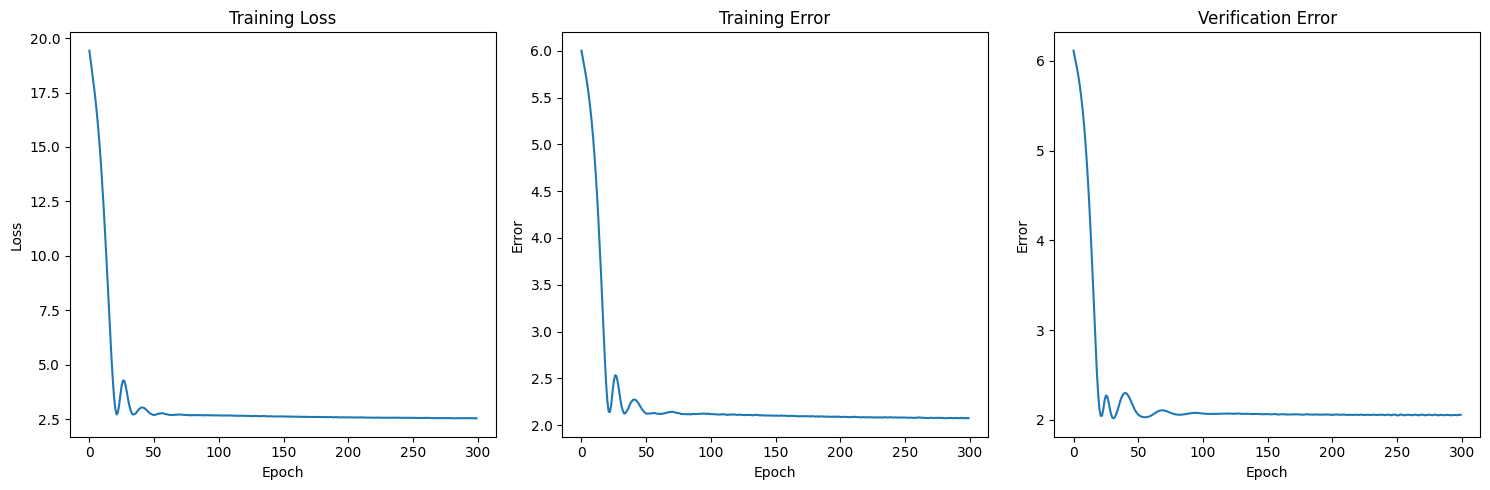

Minimum verification error: 2.0180046558380127


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from custom_datasets import GameOfLifeDatasetNoLoopNoPrepare
from models import GameOfLifeCNN

# Load the data
data = GameOfLifeDatasetNoLoopNoPrepare().data.to('cuda')
verification_number = 200
grids = data
verification_grids = grids[:verification_number]
grids = grids[verification_number:]

# Load the pre-trained model
model = GameOfLifeCNN(output_dim=1).to('cuda')
model.load_state_dict(torch.load('models/NEURIPS-GOL-model-A-rand-shape-init-unique-cloud-3.pth'))

# Get representations
reps = model(grids)
verification_reps = model(verification_grids)

# Define a function to find the glider position
def find_glider_position(grid):
    kernel = torch.ones(3, 3).to(grid.device)
    conv_result = F.conv2d(grid.unsqueeze(0).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0), padding=0)
    max_val, _ = conv_result.view(-1).max(0)
    if max_val >= 5:  # Assuming a glider has at least 5 live cells in a 3x3 grid
        y, x = divmod(conv_result.view(-1).argmax().item(), conv_result.size(3))
        return torch.tensor([x, y], device=grid.device).float()
    return torch.tensor([-1, -1], device=grid.device).float()  # Return (-1, -1) if no glider is found

# Find glider positions for all grids
positions = torch.stack([find_glider_position(grid) for grid in grids]).to('cuda')
verification_positions = torch.stack([find_glider_position(grid) for grid in verification_grids]).to('cuda')

# Define the MLP model for position prediction
class PositionPredictionMLP(nn.Module):
    def __init__(self, input_dim):
        super(PositionPredictionMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 2)  # Output 2 values for x and y
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the MLP model
mlp = PositionPredictionMLP(reps.shape[1]).to('cuda')

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

# Training loop
num_epochs = 300
losses = []
train_errors = []
verification_errors = []

for epoch in range(num_epochs):
    mlp.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = mlp(reps.detach())
    loss = criterion(outputs, positions)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    # Calculate training error
    train_error = torch.mean(torch.sqrt(torch.sum((outputs - positions) ** 2, dim=1)))
    train_errors.append(train_error.item())

    # Calculate verification error
    mlp.eval()
    with torch.no_grad():
        verification_outputs = mlp(verification_reps)
        verification_error = torch.mean(torch.sqrt(torch.sum((verification_outputs - verification_positions) ** 2, dim=1)))
        verification_errors.append(verification_error.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Error: {train_error.item():.4f}, Verification Error: {verification_error.item():.4f}')

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 3, 2)
plt.plot(train_errors)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Training Error')

plt.subplot(1, 3, 3)
plt.plot(verification_errors)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Verification Error')

plt.tight_layout()
plt.show()

print(f"Minimum verification error: {min(verification_errors)}")


# visualizing gol class

In [4]:
from info_theory_experiments.custom_datasets import GameOfLifeDatasetNoLoop 
from info_theory_experiments.utils import animate_game_of_life_no_loop

x = GameOfLifeDatasetNoLoop(
    prepare=True,
    normalize=True,
    num_simulations=50,
    time_steps=100,
    grid_size=10,
)

# grids = x.data

# ani = animate_game_of_life_no_loop(grids)

# from IPython.display import HTML
# HTML(ani.to_jshtml())


Image 0: mean = -0.00, Std Dev = 0.9974842071533203


In [5]:
from info_theory_experiments.models import GameOfLifePredictor, GameOfLifeEncoder

model = GameOfLifeEncoder(
    feature_size=3,
).to('cuda')

decoder = GameOfLifePredictor(
    grid_size=10,
    feature_size=3,
).to('cuda')

x.data = x.data.to('cuda')
print(x.data.size())

x0 = x.data[:, 0 ]
x1 = x.data[:, 1 ]

print(x0.size())
print(x1.size())

v0 = model(x0)
v1 = model(x1)

print(v0.size())
print(v1.size())

x0_pred = decoder(v0)
x1_pred = decoder(v1)

print(x0_pred.size())
print(x1_pred.size())


torch.Size([304, 2, 10, 10])
torch.Size([304, 10, 10])
torch.Size([304, 10, 10])
torch.Size([304, 3])
torch.Size([304, 3])
torch.Size([304, 10, 10])
torch.Size([304, 10, 10])


In [7]:
import torch.nn as nn
import torch
mse_loss = nn.MSELoss()

loss0 = mse_loss(torch.zeros_like(x0), x0)
print(loss0)

tensor(0.9900, device='cuda:0')


In [17]:
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch

class ConvAutoencoder(nn.Module):
    def __init__(self, grid_size=10, latent_dim=3):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * grid_size * grid_size, latent_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * grid_size * grid_size),
            nn.ReLU(),
            nn.Unflatten(1, (64, grid_size, grid_size)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Reshape input to (batch_size, 1, height, width)
        x = x.unsqueeze(1)
        
        # Encode
        encoded = self.encoder(x)
        
        # Decode
        decoded = self.decoder(encoded)
        
        # Reshape output back to (batch_size, height, width)
        return decoded.squeeze(1)


from info_theory_experiments.custom_datasets import GameOfLifeDatasetNoLoop 
from info_theory_experiments.utils import animate_game_of_life_no_loop

dataset = GameOfLifeDatasetNoLoop(
    prepare=True,
    normalize=True,
    num_simulations=10000,
    time_steps=100,
    grid_size=10,
)

# Initialize the model
latent_dim = 32 # You can adjust this value
conv_autoencoder = ConvAutoencoder(grid_size=10, latent_dim=latent_dim).to('cuda')

# Training loop
num_epochs = 50
batch_size = 200
learning_rate = 1e-3

optimizer = torch.optim.Adam(conv_autoencoder.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        batch = batch.to('cuda')
        x0 = batch[:, 0]
        # x1 = batch[:, 1]
        # Forward pass
        outputs = conv_autoencoder(x0)
        loss = criterion(outputs, x0)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Print epoch statistics
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Evaluate the model after training
with torch.no_grad():
    x0_reconstructed = conv_autoencoder(x0)
    reconstruction_loss = criterion(x0_reconstructed, x0)
    print(f"Final reconstruction loss: {reconstruction_loss.item()}")

# Visualize original and reconstructed images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(x0[0].cpu().numpy(), cmap='gray')
ax1.set_title("Original")
ax2.imshow(x0_reconstructed[0].cpu().numpy(), cmap='gray')
ax2.set_title("Reconstructed")
plt.show()

# Visualize the latent space
encoded_data = conv_autoencoder.encoder(x0.unsqueeze(1)).cpu().numpy()
plt.figure(figsize=(10, 5))
plt.plot(encoded_data[0])
plt.title(f"Latent Space Representation (dimension: {latent_dim})")
plt.xlabel("Latent Dimension")
plt.ylabel("Activation")
plt.show()

print(x0[0])

print(x0_reconstructed[0])

Image 0: mean = -0.00, Std Dev = 0.9974842071533203
Epoch [1/50], Loss: 0.9935
Epoch [2/50], Loss: 0.9900
Epoch [3/50], Loss: 0.9900
Epoch [4/50], Loss: 0.9900
Epoch [5/50], Loss: 0.9900
Epoch [6/50], Loss: 0.9900
Epoch [7/50], Loss: 0.9900
Epoch [8/50], Loss: 0.9900
Epoch [9/50], Loss: 0.9900
Epoch [10/50], Loss: 0.9900


KeyboardInterrupt: 

Epoch [1/6], Loss: 0.0654
Epoch [2/6], Loss: 0.0503
Epoch [3/6], Loss: 0.0476
Epoch [4/6], Loss: 0.0460
Epoch [5/6], Loss: 0.0448
Epoch [6/6], Loss: 0.0438


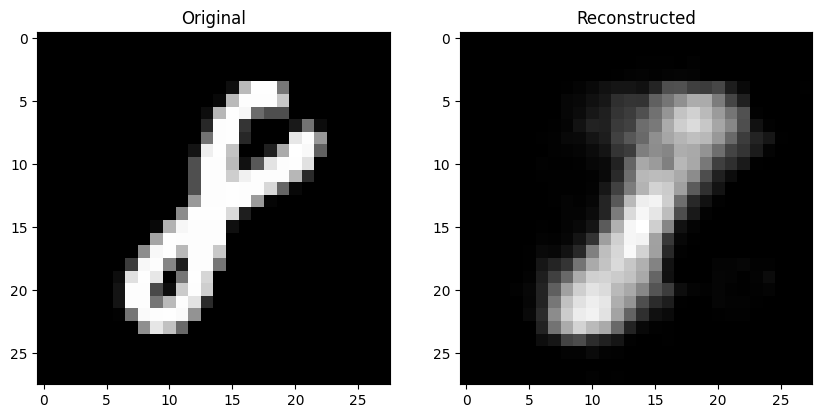

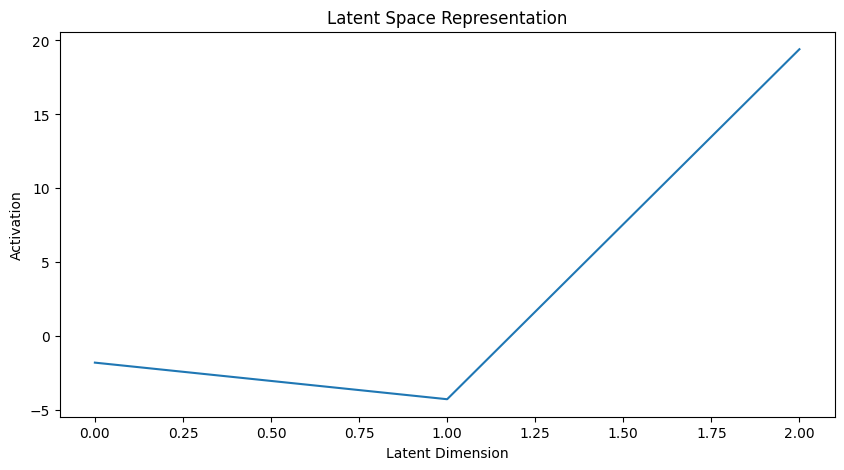

Original image:
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define the autoencoder architecture
class MNISTAutoencoder(nn.Module):
    def __init__(self, latent_dim=3):
        super(MNISTAutoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32 * 7 * 7),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Initialize the model, loss function, and optimizer
model = MNISTAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training loop
num_epochs = 6
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, data)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Print epoch statistics
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Evaluate the model after training
model.eval()
with torch.no_grad():
    # Get a batch of test images
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
    test_iter = iter(test_loader)
    images, _ = next(test_iter)
    images = images.to(device)
    
    # Reconstruct images
    reconstructed = model(images)

    # Visualize original and reconstructed images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(images.cpu().squeeze().numpy(), cmap='gray')
    ax1.set_title("Original")
    ax2.imshow(reconstructed.cpu().squeeze().numpy(), cmap='gray')
    ax2.set_title("Reconstructed")
    plt.show()

    # Visualize the latent space
    encoded_data = model.encoder(images).cpu().squeeze().numpy()
    plt.figure(figsize=(10, 5))
    plt.plot(encoded_data.flatten())
    plt.title(f"Latent Space Representation")
    plt.xlabel("Latent Dimension")
    plt.ylabel("Activation")
    plt.show()

print("Original image:")
print(images.cpu().squeeze().numpy())
print("\nReconstructed image:")
print(reconstructed.cpu().squeeze().numpy())


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from info_theory_experiments.custom_datasets import GameOfLifeDatasetNoLoop
from info_theory_experiments.models import GeneralSmileMIEstimator

class GameOfLifeEncoder(nn.Module):
    def __init__(self, latent_dim=3):
        super(GameOfLifeEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1),  # Output: 32x10x10
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),  # Output: 64x10x10
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),  # Output: 128x10x10
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 3, stride=1, padding=1),  # Output: 256x10x10
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(256),
            nn.Flatten(),
            nn.Linear(256 * 10 * 10, latent_dim),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.encoder(x)

class GameOfLifeDecoder(nn.Module):
    def __init__(self, latent_dim=3):
        super(GameOfLifeDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 10 * 10),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (256, 10, 10)),
            nn.ConvTranspose2d(256, 128, 3, stride=1, padding=1),  # Output: 128x10x10
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 3, stride=1, padding=1),  # Output: 64x10x10
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 3, stride=1, padding=1),  # Output: 32x10x10
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 1, 3, stride=1, padding=1),  # Output: 1x10x10
        )

    def forward(self, x):
        return self.decoder(x)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = GameOfLifeDatasetNoLoop(
    prepare=True,
    normalize=True,
    num_simulations=1000,
    time_steps=100,
    grid_size=10,
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Initialize the models, loss function, and optimizers
encoder = GameOfLifeEncoder().to(device)
decoder = GameOfLifeDecoder().to(device)
mse_loss = nn.MSELoss()
optimizer_encoder = optim.Adam(encoder.parameters(), lr=1e-3)
optimizer_decoder = optim.Adam(decoder.parameters(), lr=1e-4)

decoupled_estimator = GeneralSmileMIEstimator(
    x_dim=3,
    y_dim=3,
    critic_output_size=32,
    x_critics_hidden_sizes=[512, 512, 512],
    y_critics_hidden_sizes=[512, 512, 512],
    clip=5,
    include_bias=True,
).to(device)

decoupled_optimizer = optim.Adam(decoupled_estimator.parameters(), lr=1e-3)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    total_decoder_loss = 0
    total_encoder_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data0 = data[:, 0].to(device).unsqueeze(1)
        data1 = data[:, 1].to(device).unsqueeze(1)

        # Forward pass
        data1_pred = decoder(encoder(data0))

        # Decoder loss (minimize MSE)
        decoder_loss = mse_loss(data1_pred, data1)

        # Update decoder
        if batch_idx % 10 == 0:
            optimizer_decoder.zero_grad()
            decoder_loss.backward()
            optimizer_decoder.step()

        # update decoupled estimator
        optimizer_encoder.zero_grad()
        v0 = encoder(data0)
        v1 = encoder(data1)
        mi = decoupled_estimator(v0, v1)
        decoupled_loss = -mi # maximize MI
        decoupled_loss.backward()
        decoupled_optimizer.step()

        # Recompute the forward pass for encoder loss
        data1_pred = decoder(encoder(data0))
        v0 = encoder(data0)
        v1 = encoder(data1)
        mi = decoupled_estimator(v0, v1)
        encoder_loss = - 0.1 * mse_loss(data1_pred, data1) - mi
        # Update encoder
        optimizer_encoder.zero_grad()
        encoder_loss.backward()
        optimizer_encoder.step()
        
        total_decoder_loss += decoder_loss.item()
        total_encoder_loss += encoder_loss.item()
    
    # Print epoch statistics
    avg_decoder_loss = total_decoder_loss / len(train_loader)
    avg_encoder_loss = total_encoder_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Decoder Loss: {avg_decoder_loss:.4f}, Encoder Loss: {avg_encoder_loss:.4f}, MI: {mi.item():.4f}')

Image 0: mean = -0.00, Std Dev = 0.9974842071533203
Epoch [1/30], Decoder Loss: 2.7806, Encoder Loss: 0.0067, MI: -0.1082
Epoch [2/30], Decoder Loss: 1.1931, Encoder Loss: 0.4770, MI: -0.0190
Epoch [3/30], Decoder Loss: 1.0045, Encoder Loss: 0.9899, MI: -0.1206
Epoch [4/30], Decoder Loss: 0.8587, Encoder Loss: 0.0481, MI: -0.0056
Epoch [5/30], Decoder Loss: 0.7954, Encoder Loss: 0.0184, MI: -0.0074
Epoch [6/30], Decoder Loss: 0.7735, Encoder Loss: 0.0052, MI: -0.0133
Epoch [7/30], Decoder Loss: 0.7462, Encoder Loss: 0.0252, MI: -0.0196
Epoch [8/30], Decoder Loss: 0.7478, Encoder Loss: 0.0051, MI: -0.0001
Epoch [9/30], Decoder Loss: 0.7097, Encoder Loss: -0.0000, MI: 0.0000
Epoch [10/30], Decoder Loss: 0.7114, Encoder Loss: 0.0001, MI: 0.0000
Epoch [11/30], Decoder Loss: 0.6880, Encoder Loss: 0.0000, MI: -0.0000
Epoch [12/30], Decoder Loss: 0.6674, Encoder Loss: 0.0000, MI: -0.0000
Epoch [13/30], Decoder Loss: 0.6464, Encoder Loss: -0.0000, MI: -0.0000
Epoch [14/30], Decoder Loss: 0.632

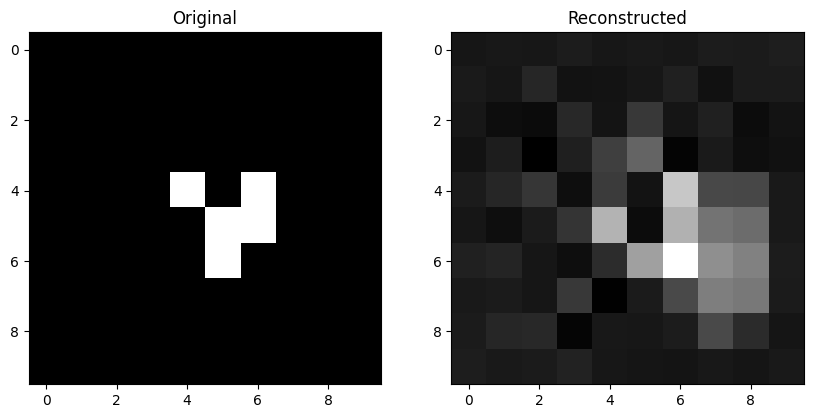

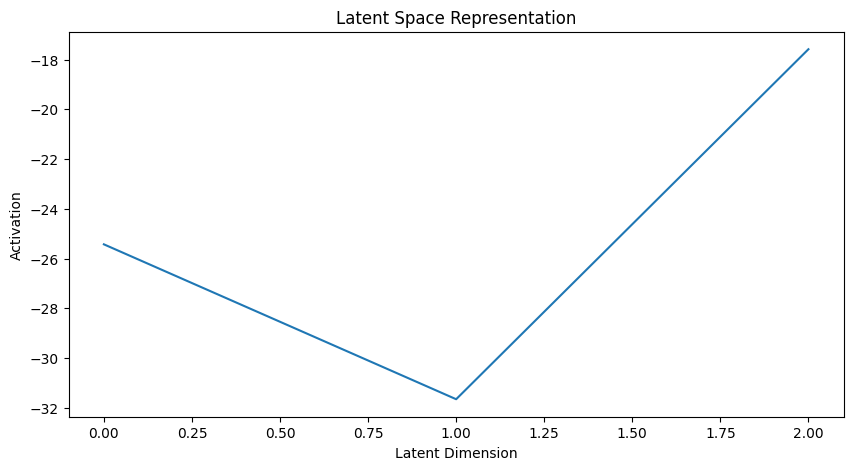

In [8]:
# Evaluate the model after training
encoder.eval()
decoder.eval()
with torch.no_grad():
    # Get a batch of test images
    test_loader = torch.utils.data.DataLoader(train_dataset[8:500], batch_size=1, shuffle=True)
    test_iter = iter(test_loader)
    images= next(test_iter)[:, 0]
    images = images.to(device).unsqueeze(1)

    # Reconstruct images
    reconstructed = decoder(encoder(images))

    # Visualize original and reconstructed images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(images.cpu().squeeze().numpy(), cmap='gray')
    ax1.set_title("Original")
    ax2.imshow(reconstructed.cpu().squeeze().numpy(), cmap='gray')
    ax2.set_title("Reconstructed")
    plt.show()

    # Visualize the latent space
    encoded_data = encoder(images).cpu().squeeze().numpy()
    plt.figure(figsize=(10, 5))
    plt.plot(encoded_data.flatten())
    plt.title(f"Latent Space Representation")
    plt.xlabel("Latent Dimension")
    plt.ylabel("Activation")
    plt.show()



In [13]:
from info_theory_experiments.trainers_GOL_conv_net import train_feature_network
seed = 3
torch.manual_seed(seed)
config = {
    "torch_seed": seed,
    "dataset_type": "gol",
    "num_atoms": 100,
    "batch_size": 1000,
    "train_mode": False,
    "train_model_B": False,
    "adjust_Psi": False,
    "clip": 5,
    "feature_size": 3,
    "epochs": 10,
    "downward_critics_config": {
        "hidden_sizes_v_critic": [512, 1024, 1024, 512],
        "hidden_sizes_xi_critic": [512, 512, 512],
        "critic_output_size": 32,
        "lr": 1e-3,
        "bias": True,
        "weight_decay": 0,
    },
    
    "decoupled_critic_config": {
        "hidden_sizes_encoder_1": [512, 512, 512],
        "hidden_sizes_encoder_2": [512, 512, 512],
        "critic_output_size": 32,
        "lr": 1e-3,
        "bias": True,
        "weight_decay": 0,
    },
}

project_name = "GOL-min-mse-max-mi-verification"

_, _ = train_feature_network(
    config=config,
    trainloader=train_loader,
    feature_network_training=encoder,
    project_name=project_name,
)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([128, 3])


Training:   0%|          | 0/10 [00:03<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 15.70 GiB of which 3.19 MiB is free. Process 853265 has 10.25 GiB memory in use. Including non-PyTorch memory, this process has 5.35 GiB memory in use. Of the allocated memory 5.05 GiB is allocated by PyTorch, and 8.01 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)